# Masalah

Dalam pengawasan reputasi online, perusahaan perlu dapat mengidentifikasi apakah ulasan atau komentar pelanggan tentang produk atau layanan mereka memiliki respon emosi seperti apa. Hal ini penting untuk mengetahui apakah pelanggan puas atau tidak dengan pengalaman mereka, sehingga perusahaan dapat merespons dengan cepat terhadap masalah yang muncul atau memperbaiki aspek-aspek yang tidak memuaskan dan mampu memberikan respon terhadap emosi pelanggan dengan sesuai.

Model: BERTweet https://huggingface.co/vinai/bertweet-base

Sumber dataset: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [ ]:
CUDA_LAUNCH_BLOCKING="1"

In [ ]:
!pip install transformers
!pip install datasets
!pip3 install emoji==0.6.0

In [ ]:
from datasets import load_dataset
import transformers
from transformers import AutoModel, AutoTokenizer
import torch
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, average_precision_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
%matplotlib inline

nltk.download("stopwords")
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


GPU is available


### Import Hugging Face

In [ ]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization = True, use_fast=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

# Data Preprocessing

## Import Data

### Data Train

In [ ]:
import pandas as pd

data_train = pd.read_csv('train.txt', names=['body', 'target'], sep=';')

display(data_train)

,body,target
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


### Data Test

In [ ]:
data_test = pd.read_csv('test.txt', names=['body', 'target'], sep=';')

display(data_test)

,body,target
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


### Data Val

In [ ]:
data_val = pd.read_csv('val.txt', names=['body', 'target'], sep=';')

display(data_val)

,body,target
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


## Assessing

In [ ]:
df_train = data_train
df_val = data_val
df_test = data_test

### Data Train

In [ ]:
#check if the data is balanced or not
df_train.target.value_counts()

target
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [ ]:
#check if the data is balanced or not
df_train.target.value_counts() / df_train.shape[0] *100

target
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64

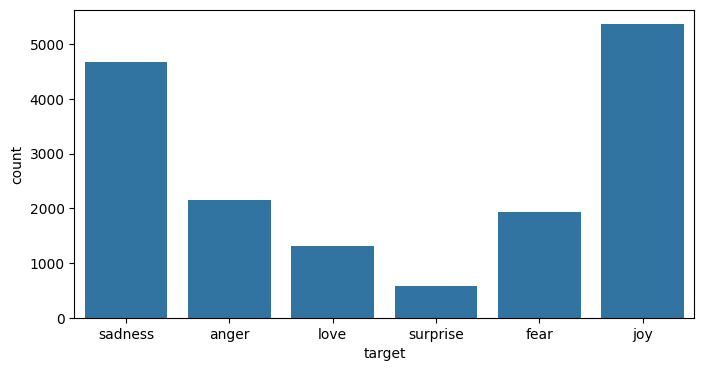

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='target', data=df_train);

In [ ]:
#print the number of null values in each column
df_train.isnull().sum()

body      0
target    0
dtype: int64

Data tidak berisi nilai null

In [ ]:
#print the number of duplicated values
df_train.duplicated().sum()

1

Hanya ada satu baris yang terduplikasi tetapi kita perlu memeriksa juga apakah ada baris yang memiliki teks yang sama tetapi emosinya berbeda

In [ ]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['body'].duplicated() == True]

,body,target
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [ ]:
df_train[df_train['body'] == df_train.iloc[14313]['body']]


,body,target
13653,i could feel myself hit this strange foggy wall,fear
14313,i could feel myself hit this strange foggy wall,surprise


Bisa terlihat bahwa data memiliki text yang sama namun target yang berbeda. Kita perlu memperbaikinya.

In [ ]:
#removing duplicated text
index = df_train[df_train['body'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['body'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

stop_words
5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

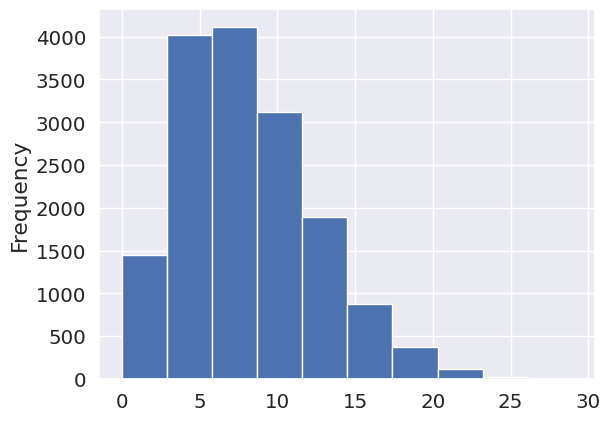

In [ ]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

### Data Test

In [ ]:
#check if the data is balanced or not
df_test.target.value_counts()

target
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

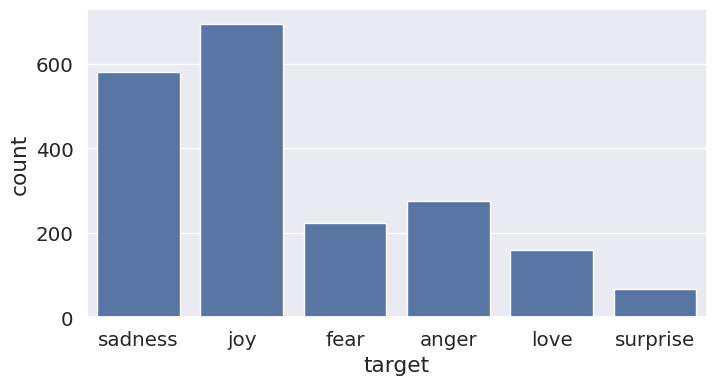

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='target', data=df_test);

In [ ]:
#print the number of null values in each column
df_test.isnull().sum()

body      0
target    0
dtype: int64

In [ ]:
#print the rows which are duplicated
df_test[df_test['body'].duplicated() == True]

,body,target


<Axes: ylabel='Frequency'>

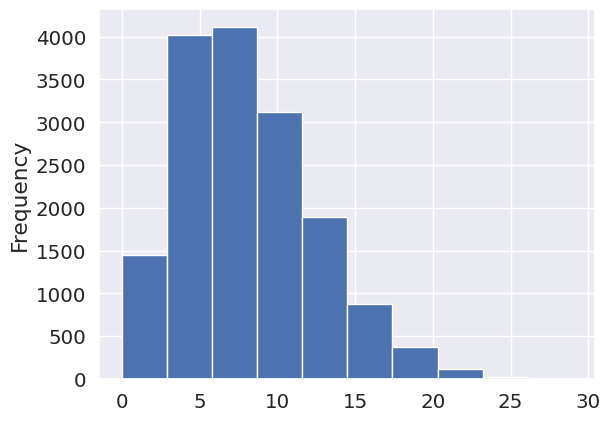

In [ ]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

Tidak ada data test yang terduplikasi

In [ ]:
#Count the number of stopwords in the data
temp =df_test.copy()
temp['stop_words'] = temp['body'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()


stop_words
7     184
6     179
3     175
5     175
4     163
9     163
8     139
10    123
2     118
11    115
12     84
13     71
15     61
14     58
1      42
16     40
17     31
18     22
20     17
19     11
21     10
0       8
23      7
24      2
22      2
Name: count, dtype: int64

### Data Validation

In [ ]:
#check if the data is balanced or not
df_val.target.value_counts()

target
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

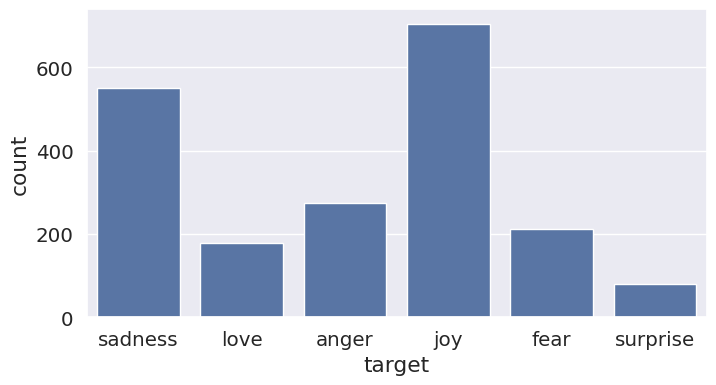

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='target', data=df_val);

In [ ]:
#print the number of null values in each column
df_val.isnull().sum()

body      0
target    0
dtype: int64

In [ ]:
#print the number of duplicated values
df_val.duplicated().sum()

0

In [ ]:
#print the rows which are duplicated
df_val[df_val['body'].duplicated() == True]

,body,target
603,i have had several new members tell me how com...,joy
1993,i feel so tortured by it,anger


In [ ]:
df_val[df_val['body'] == df_val.iloc[1993]['body']]


,body,target
774,i feel so tortured by it,fear
1993,i feel so tortured by it,anger


In [ ]:
#removing duplicated text
index = df_val[df_val['body'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [ ]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['body'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]


stop_words
7     190
5     175
8     173
6     160
3     160
10    150
9     146
4     145
2     133
11    103
Name: count, dtype: int64

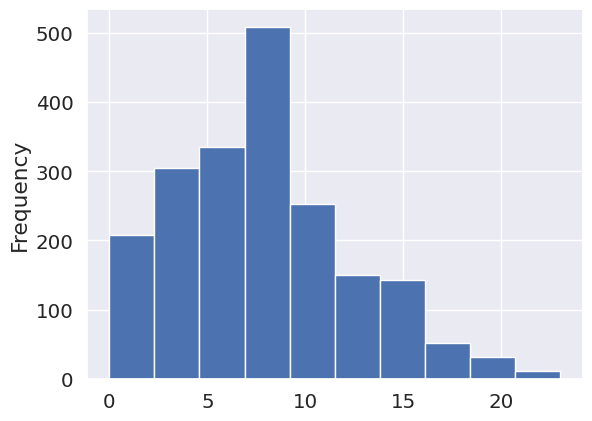

In [ ]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

## Cleaning

In [ ]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]

    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):

    text = text.split()

    text=[y.lower() for y in text]

    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df.body=df.body.apply(lambda text : lower_case(text))
    df.body=df.body.apply(lambda text : remove_stop_words(text))
    df.body=df.body.apply(lambda text : Removing_numbers(text))
    df.body=df.body.apply(lambda text : Removing_punctuations(text))
    df.body=df.body.apply(lambda text : Removing_urls(text))
    df.body=df.body.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence



In [ ]:
normalized_sentence("My Name is Mohamed. @Tweets,  plays 2022  Egypt_")

'name mohamed tweet play egypt'

In [ ]:
df_train= normalize_text(df_train)
df_val= normalize_text(df_val)
df_test= normalize_text(df_test)

## Encoding

In [ ]:
# Find unique values in the 'sentiment' column
unique_sentiments = df_train['target'].unique()

# Display the unique sentiments
print(unique_sentiments)

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [ ]:
sentiment_mapping = {
    'sadness': 0,
    'joy': 1,
    'fear': 2,
    'anger': 3,
    'love': 4,
    'surprise': 5
}

In [ ]:
df_train['target'] = df_train['target'].map(sentiment_mapping)
df_test['target'] = df_test['target'].map(sentiment_mapping)
df_val['target'] = df_val['target'].map(sentiment_mapping)

In [ ]:
df_train.head()

,body,target
0,didnt feel humiliated,0
1,go feeling hopeless damned hopeful around some...,0
2,im grabbing minute post feel greedy wrong,3
3,ever feeling nostalgic fireplace know still pr...,4
4,feeling grouchy,3


In [ ]:
df_test.head()

,body,target
0,im feeling rather rotten im ambitious right,0
1,im updating blog feel shitty,0
2,never make separate ever want feel like ashamed,0
3,left bouquet red yellow tulip arm feeling slig...,1
4,feeling little vain one,0


In [ ]:
df_val.head()

,body,target
0,im feeling quite sad sorry ill snap soon,0
1,feel like still looking blank canvas blank pie...,0
2,feel like faithful servant,4
3,feeling cranky blue,3
4,treat feeling festive,1


# Training Model (BERTweet)

In [ ]:
class SATweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation= True,
      return_token_type_ids=False,
      padding = 'max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):

    ds = SATweetDataset(
        tweets=df.body.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )


In [ ]:
PRE_TRAINED_MODEL_NAME = "vinai/bertweet-base"

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = bertweet.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    #output = self.drop(pooled_output)
    output = pooled_output
    return self.out(output)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer,  device, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  tweets_content = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      probs = nn.functional.softmax(outputs, dim=1)

      tweets_content.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweets_content, predictions, prediction_probs, real_values

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

In [ ]:
def avg_rec(y_test, y_pred):
    rec_n, rec_u, rec_p = recall_score(y_test, y_pred, average=None)
    return (1/3) * (rec_n+ rec_u+ rec_p)

In [ ]:
def f1_np(y_test, y_pred):
    f1_n, _,f1_p = f1_score(y_test, y_pred, average=None)
    return 0.5*(f1_n+f1_p)

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


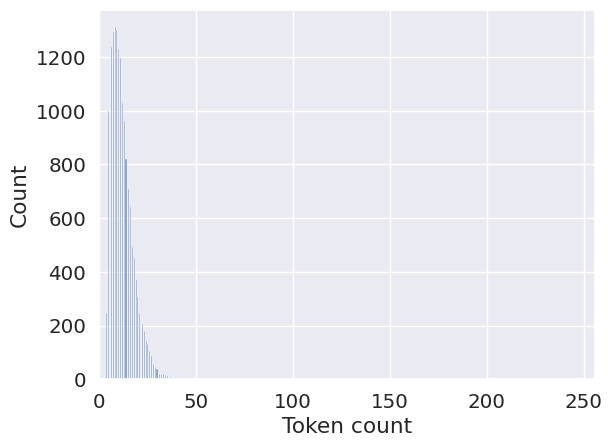

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
MAX_LEN

67

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 6
class_names = ['sadness','anger','love','surprise','fear','joy']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 67])
torch.Size([32, 67])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'bertweet_best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train loss 0.950400433793664 accuracy 0.6646627841442796
Val loss 0.31580616912198445 accuracy 0.9054054054054054

Epoch 2/30
----------
Train loss 0.2537419352196157 accuracy 0.9189053791721461
Val loss 0.20502520926178447 accuracy 0.9279279279279279

Epoch 3/30
----------
Train loss 0.16633586907573045 accuracy 0.9370029432024548
Val loss 0.15453470675718217 accuracy 0.9364364364364365

Epoch 4/30
----------
Train loss 0.12421844258531928 accuracy 0.9472728411296888
Val loss 0.1635409497788974 accuracy 0.933933933933934

Epoch 5/30
----------
Train loss 0.1060589353744872 accuracy 0.9527208967374288
Val loss 0.14125878802899802 accuracy 0.9424424424424425

Epoch 6/30
----------
Train loss 0.09074743323260918 accuracy 0.9568539044398522
Val loss 0.1435431210058076 accuracy 0.93993993993994

Epoch 7/30
----------
Train loss 0.08482638866873458 accuracy 0.9582315736739934
Val loss 0.1578978556577885 accuracy 0.9374374374374375

Epoch 8/30
----------
Train loss 0.07813683045469225 accura

In [ ]:
model.load_state_dict(torch.load('bertweet_best_model_state.bin'))

<All keys matched successfully>

# Evaluate Model (BERTweet)

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9295

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     sadness       0.96      0.97      0.97       581
       anger       0.96      0.93      0.94       695
        love       0.86      0.98      0.91       224
    surprise       0.95      0.91      0.93       275
        fear       0.81      0.87      0.84       159
         joy       0.79      0.68      0.73        66

    accuracy                           0.93      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.93      0.93      0.93      2000



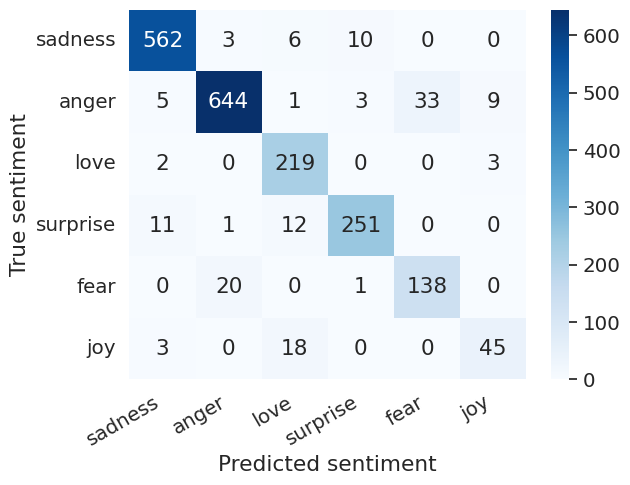

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.9295

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.9295570834280944

# Training Model (LSTM)

Word embedding using glove and sequence model

In [ ]:
# Modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [121]:
# !unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


## Text Preprocessing

In [ ]:
#Preprocess text
X_train = df_train['body']
y_train = df_train['target']

X_test = df_test['body']
y_test = df_test['target']

X_val = df_val['body']
y_val = df_val['target']

0 = Sadness<br>
1 = Joy<br>
2 = Fear<br>
3 = Anger<br>
4 = Love<br>
5 = Surprise

In [ ]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [ ]:
#print the labels after encoding
print(set(y_train))

{0, 1, 2, 3, 4, 5}


In [ ]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
print(y_train)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


## Tokenizing

In [ ]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [ ]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())

[[53], [2], [531]]

In [ ]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

## Padding

The vectors we obtain are generally not of equal lengths

For that, we might need to pad the sequences to max len.

In [ ]:
df_test.shape

(2000, 2)

In [ ]:
maxlen = max([len(t) for t in df_train['body']])
maxlen

229

In [ ]:
X_train = pad_sequences(sequences_train, maxlen=maxlen, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlen, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=maxlen, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 14325


In [ ]:
#before
sequences_train[0]

[53, 2, 531]

In [ ]:
#after
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## Word Embedding

**This code defines the following variables:**

**path_to_glove_file**: The file path to the GloVe word vectors file.

**num_tokens**: The size of the vocabulary. This is typically the number of unique words in the dataset.

**embedding_dim**: The dimensionality of the word vectors. This is usually set to a fixed value (e.g., 200, 300, etc.) depending on the size of the word vectors file that is being used.

**hits**: A counter for the number of words that are found in the embeddings_index dictionary.

**misses**: A counter for the number of words that are not found in the embeddings_index dictionary.

**embeddings_index**: A dictionary that will store the word vectors, with the words as keys and the word vectors as values.

In [122]:
# Read GloVE embeddings

path_to_glove_file = 'model/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features
hits = 0
misses = 0
embeddings_index = {}

I will intialize an embedding matrix with all zero values and then looping through the vocabulary (as defined by the tokenizer object) to assign word vectors to the corresponding rows of the embedding matrix. The word_index attribute of the tokenizer object is a dictionary that maps words to their indices in the vocabulary.

The embedding matrix will have a size of num_tokens rows and embedding_dim columns, where num_tokens is the size of the vocabulary and embedding_dim is the dimensionality of the word vectors.

For each word in the vocabulary, the code looks up the corresponding word vector in the embeddings_index dictionary and assigns it to the corresponding row of the embedding matrix. If the word is not found in the embeddings_index dictionary (i.e., if embedding_vector is None), the code increments the misses counter and the row of the embedding matrix remains all-zeros. If the word is found in the embeddings_index dictionary, the code increments the hits counter and assigns the word vector to the corresponding row of the embedding matrix. Finally, the code prints out the number of words that were converted (hits) and the number that were not found in the embeddings_index dictionary (misses).

In [123]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Found 400000 word vectors.
Converted 13243 words (1081 misses)


## Modeling

**The model consists of several layers:**

1. An Embedding layer that takes in integer-encoded text and looks up the embedding vector for each word in the input. The input length is set to the length of the input sequences, and the weights are initialized with an embedding matrix that has been pre-trained on a large dataset. The embedding layer is not trainable, meaning that the weights of this layer will not be updated during training.

2. Three Bidirectional layers, each of which applies a forward and backward LSTM to the input. LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. The dropout and recurrent dropout arguments specify the dropout rate to apply to the inputs and recurrent inputs of the LSTMs, respectively. The return_sequences argument specifies whether the LSTM should return the full sequences of outputs or just the last output of each sequence.

3. A Dense layer that applies a linear transformation to the input to produce the output. The output has 6 units and uses the 'softmax' activation function, which means that it will output a probability distribution over the 6 classes.

In [124]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 229, 200)          2865000   
                                                                 
 bidirectional (Bidirection  (None, 229, 512)          935936    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 229, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

**This is the summary of a deep learning model built using the Keras functional API. The model consists of several layers, each of which has a specific type and number of parameters.**

1. The first layer is an "Embedding" layer, which takes in integer-encoded text and looks up the embedding vector for each word in the input. The output of this layer is a 3D tensor with shape (batch_size, sequence_length, embedding_dim), where batch_size is the number of examples in the batch, sequence_length is the length of the input sequences, and embedding_dim is the size of the embedding vectors. In this case, the input sequences are 229 words long and the embedding vectors are 200 dimensions. The embedding layer has a total of 2,863,600 trainable parameters.

2. The next three layers are "Bidirectional" layers, which apply a forward and backward LSTM to the input. LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. The output of each bidirectional layer is a 3D tensor with shape (batch_size, sequence_length, units), where units is the number of LSTM units in the layer. In this case, the first bidirectional layer has 512 units, the second has 256 units, and the third has 256 units. Each of these layers has a large number of trainable parameters, as LSTMs are complex models with many internal weights.

3. The final layer is a "Dense" layer, which applies a linear transformation to the input to produce the output. In this case, the output has shape (batch_size, 6), indicating that there are 6 classes. The dense layer has a total of 1,542 trainable parameters.

Overall, the model has a total of 4,851,702 trainable parameters and 2,863,600 non-trainable parameters.

In [125]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [126]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
63/63 [==============================] - 414s 6s/step - loss: 1.1882 - accuracy: 0.5583 - val_loss: 0.6134 - val_accuracy: 0.7938
Epoch 2/30
63/63 [==============================] - 378s 6s/step - loss: 0.4665 - accuracy: 0.8349 - val_loss: 0.2615 - val_accuracy: 0.9009
Epoch 3/30
63/63 [==============================] - 377s 6s/step - loss: 0.2405 - accuracy: 0.9071 - val_loss: 0.2051 - val_accuracy: 0.9109
Epoch 4/30
63/63 [==============================] - 385s 6s/step - loss: 0.1591 - accuracy: 0.9306 - val_loss: 0.1565 - val_accuracy: 0.9299
Epoch 5/30
63/63 [==============================] - 380s 6s/step - loss: 0.1226 - accuracy: 0.9446 - val_loss: 0.1461 - val_accuracy: 0.9284
Epoch 6/30
63/63 [==============================] - 391s 6s/step - loss: 0.1102 - accuracy: 0.9493 - val_loss: 0.1262 - val_accuracy: 0.9379
Epoch 7/30
63/63 [==============================] - 372s 6s/step - loss: 0.0956 - accuracy: 0.9549 - val_loss: 0.1342 - val_accuracy: 0.9329
Epoch 8/30
63

In [127]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 31s 487ms/step - loss: 0.1262 - accuracy: 0.9379


[0.1261502355337143, 0.9379379153251648]

In [128]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['target']), y_pred))

63/63 [==============================] - 32s 482ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       581
           1       0.95      0.93      0.94       695
           2       0.85      0.93      0.89       224
           3       0.95      0.91      0.93       275
           4       0.80      0.88      0.84       159
           5       0.74      0.74      0.74        66

    accuracy                           0.92      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.93      0.92      0.92      2000



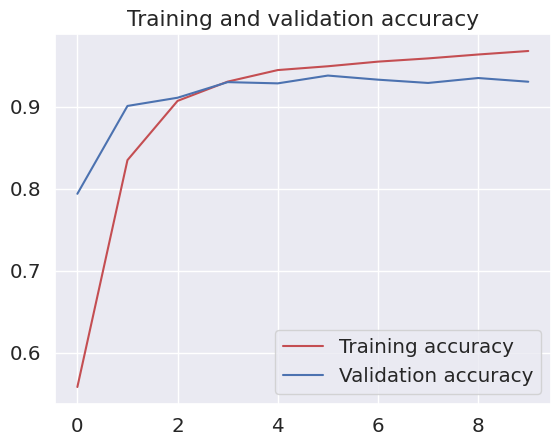

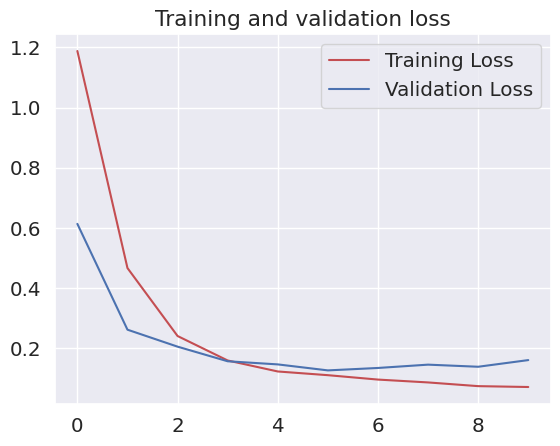

In [132]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**So, you may asking when I give a sentence to the model how the classification will done?**

1. First, the model will convert the words in the sentence into numerical representations, also known as word embeddings. These word embeddings capture the meaning of the words and their relationships to each other in a continuous vector space.

2. The word embeddings for each word in the sentence are then input to two separate LSTM models: one that processes the sequence forwards and one that processes it backwards. At each time step, each LSTM processes the current word embedding and the previous hidden state to produce a new hidden state. The hidden state at each time step is a combination of the previous hidden state and the current input, and it captures the information from all the previous time steps in the sequence.

3. After processing all the words in the sentence, the two LSTMs will have final hidden states that encode the meaning of the sentence from both the forwards and backwards directions. These final hidden states are then combined and used to make a prediction.

In [145]:
sentence= 'The unexpected fireworks lit up the night sky, leaving everyone in amazed.'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

The unexpected fireworks lit up the night sky, leaving everyone in amazed.
1/1 [==============================] - 1s 820ms/step
5 : 0.8417259454727173




0 = Sadness<br>
1 = Joy<br>
2 = Fear<br>
3 = Anger<br>
4 = Love<br>
5 = Surprise

In [134]:
model.save('lstm_emotion_recognition_eng.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
